(c) 2025 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Import base libraries
import os
import glob
import gc
import pickle
import warnings

# Import JAX-related libraries
import jax
from jax import random
import jax.numpy as jnp
from numpyro.optim import Adam
import numpyro

# Import numpy for array manipulation
import numpy as np
# Import statsmodels for statistical modeling
import statsmodels.api as sm
# Import scipy for special functions
import scipy as sp
# Import scikit-learn for PCA
from sklearn.decomposition import PCA
# Import umap-learn for UMAP
from umap import UMAP
# Import library to load h5ad files
import scanpy as sc
# Import pandas for data manipulation
import pandas as pd
# Import scribe
import scribe
# Import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# Set plotting style
scribe.viz.matplotlib_style()

# Import colors
color_palette = scribe.viz.colors()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exploratory data analysis of `10xGenomics 50%:50% Jurkat:293T Cell Mixture` dataset

In this notebook, we will perform an exploratory data analysis of the `10xGenomics 50%:50% Jurkat:293T Cell Mixture` dataset. This is a public dataset provided by 10xGenomics with a mixture of Jurkat and 293T cells.

## Raw counts exploratory data analysis

Let's begin by listing the files in the dataset directory.

In [2]:
# Define the path to the dataset
DATA_DIR = f"{scribe.utils.git_root()}/data/10xGenomics/50-50_Jurkat-293T_mixture"

# List all files in directory
files = glob.glob(f"{DATA_DIR}/*")

files

['/app/data/10xGenomics/50-50_Jurkat-293T_mixture/barcodes.tsv',
 '/app/data/10xGenomics/50-50_Jurkat-293T_mixture/README.md',
 '/app/data/10xGenomics/50-50_Jurkat-293T_mixture/genes.tsv',
 '/app/data/10xGenomics/50-50_Jurkat-293T_mixture/data.h5ad',
 '/app/data/10xGenomics/50-50_Jurkat-293T_mixture/matrix.mtx']

The data is contained in the `matrix.mtx` file. We can load it using `scanpy.read_mtx`.

In [3]:
# Load the data
data = sc.read_mtx(f"{DATA_DIR}/matrix.mtx")

# Transpose the matrix to have cells as rows and genes as columns
data = data.T  

data

AnnData object with n_obs × n_vars = 3388 × 32738

This file format is a bit unusual as the metadata is not contained in the file, but in separate files. Let's load the metadata files.

In [4]:
# Load the genes.tsv file
genes = pd.read_csv(f"{DATA_DIR}/genes.tsv", sep="\t", header=None)

genes.head(5)

,0,1
0,ENSG00000243485,MIR1302-10
1,ENSG00000237613,FAM138A
2,ENSG00000186092,OR4F5
3,ENSG00000238009,RP11-34P13.7
4,ENSG00000239945,RP11-34P13.8


In [5]:
# Load the barcodes.tsv file
barcodes = pd.read_csv(f"{DATA_DIR}/barcodes.tsv", sep="\t", header=None)

barcodes.head(5)

,0
0,AAACATACAGCTAC-1
1,AAACATTGTAAGGA-1
2,AAACCGTGGCGTAT-1
3,AAACGCACTACTGG-1
4,AAACGCTGAAGATG-1


This is the metadata that should be included in the `matrix.mtx` file. Let's add it to the `data` object.

In [6]:
# Transpose the data matrix and add metadata
data.var_names = genes.iloc[:, 0]  # Now genes (var) should match
data.obs_names = barcodes.iloc[:, 0]  # And barcodes (obs) should match

# Optional: Add gene symbols as additional metadata
data.var['name'] = genes.iloc[:, 1].values

data

AnnData object with n_obs × n_vars = 3388 × 32738
    var: 'name'

Let's save this object as an `h5ad` file.

In [7]:
# Save the data object to an h5ad file
data.write_h5ad(f"{DATA_DIR}/data.h5ad")

# Convert the data object to a dataframe
df = data.to_df()

df.head(5)

,ENSG00000243485,ENSG00000237613,ENSG00000186092,ENSG00000238009,ENSG00000239945,ENSG00000237683,ENSG00000239906,ENSG00000241599,ENSG00000228463,ENSG00000237094,...,ENSG00000217792,ENSG00000268276,ENSG00000148828,ENSG00000215700,ENSG00000215699,ENSG00000215635,ENSG00000268590,ENSG00000251180,ENSG00000215616,ENSG00000215611
AAACATACAGCTAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGTAAGGA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGGCGTAT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCACTACTGG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACGCTGAAGATG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we can begin the exploratory data analysis.

Let's begin by plotting the distribution of total UMI counts per cell.

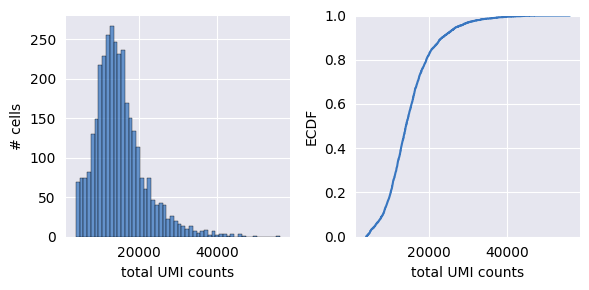

In [8]:
# Initialize figure
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Compute total counts per cell removing the first column (gene names)
total_counts = df.sum(axis=1)

# Plot the distribution of total counts per cell
sns.histplot(total_counts, ax=axes[0], color=color_palette['blue'])
sns.ecdfplot(total_counts, ax=axes[1], color=color_palette['blue'])

# Set title and labels
axes[0].set_xlabel('total UMI counts')
axes[0].set_ylabel('# cells')
axes[1].set_xlabel('total UMI counts')
axes[1].set_ylabel('ECDF')

plt.tight_layout()

This is a reasonably looking distribution. There are no extreme outliers on either end of the distribution. However, there is an obvious cutoff on the left side of the distribution, where cells with very few UMIs must have been removed.

Let's now perfomr PCA on the data and plot the first two principal components.

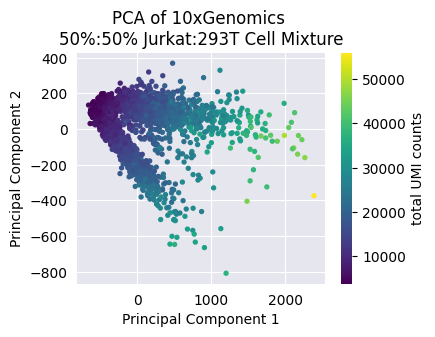

In [9]:
# Perform PCA on the data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df.values)

# Initialize figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the first two principal components
scatter = ax.scatter(
    pca_result[:, 0], 
    pca_result[:, 1], 
    c=total_counts, 
    cmap='viridis',
    s=8
)

# Label axes
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
# Set title
ax.set_title('PCA of 10xGenomics \n50%:50% Jurkat:293T Cell Mixture')

plt.colorbar(scatter, ax=ax, label='total UMI counts')

From this projection, we can sort of see a separation between the two cell types. However, it is not very clear. Let's try using UMAP.

In [10]:
# Initialize UMAP
umap = UMAP(n_components=2)
# Fit UMAP
umap_result = umap.fit_transform(df.values)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Now, let's plot the UMAP.

Text(0.5, 1.0, 'UMAP of 10xGenomics \n50%:50% Jurkat:293T Cell Mixture')

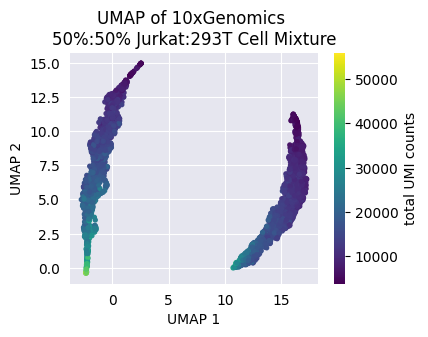

In [11]:
# Initialize figure
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the UMAP
scatter = ax.scatter(
    umap_result[:, 0], 
    umap_result[:, 1], 
    c=total_counts, 
    cmap='viridis',
    s=8
)

# Add colorbar
plt.colorbar(scatter, ax=ax, label='total UMI counts')

# Label axes
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
# Set title
ax.set_title('UMAP of 10xGenomics \n50%:50% Jurkat:293T Cell Mixture')


UMAP **clearly** shows a separation between the two cell types divided by the first UMAP dimension. Let's quantify the proportion of cells on each side of the UMAP dimension.

In [12]:
# Quantify proportion of cells with UMAP 1 < 5
count_low = np.mean(umap_result[:, 0] < 5)
count_high = np.mean(umap_result[:, 0] > 5)

# Print results
print(f"Proportion of cells with UMAP 1 < 5: {count_low / (count_low + count_high):.2%}")
print(f"Proportion of cells with UMAP 1 > 5: {count_high / (count_low + count_high):.2%}")

Proportion of cells with UMAP 1 < 5: 47.70%
Proportion of cells with UMAP 1 > 5: 52.30%
